#PROJET 3 Concevez une application au service de la santé publique

#NETTOYAGE DU DATASET

#Récupération des data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree
import scipy.stats as st

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [ ]:
data = pd.read_csv("datanutri.csv",sep = '\t',low_memory=False)

In [ ]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,NaN,NaN,courte paille,courte-paille,"Epicerie, Condiments, Sauces, Moutardes","en:groceries,en:condiments,en:sauces,en:mustards","Groceries,Condiments,Sauces,Mustards",NaN,NaN,NaN,NaN,Delois france,fr:delois-france,fr:delois-france,NaN,NaN,NaN,NaN,NaN,NaN,courte paille,France,en:france,France,eau graines de téguments de moutarde vinaigre ...,en:mustard,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,NaN,NaN,Watt,watt,Xsf,fr:xsf,fr:xsf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Analyse descriptive

In [ ]:
#Nombre d'entrée
len(data)

1405001

In [ ]:
#nombre d'indicateur
len(data.columns)

181

In [ ]:
pd.options.display.max_rows = 200

In [ ]:
#Liste indicateur
data.iloc[1]

code                                                                              0000000000031
url                                           http://world-en.openfoodfacts.org/product/0000...
creator                                                                                isagoofy
created_t                                                                            1539464774
created_datetime                                                           2018-10-13T21:06:14Z
last_modified_t                                                                      1539464817
last_modified_datetime                                                     2018-10-13T21:06:57Z
product_name                                                                              Cacao
generic_name                                                                                NaN
quantity                                                                                  130 g
packaging                               

#Nettoyage du data set

###Suppression des entrées n'ayant pas de Nutri-score

In [ ]:
#sépartion du data set en deux parties, l'un avec le nutriscore et l'autre sans le nutri score
df_bool_NaN = data.copy()

df_bool_NaN['bool'] = df_bool_NaN['nutrition-score-fr_100g'].isna() 
masque_bool_true= df_bool_NaN['bool'] == True
masque_bool_false= df_bool_NaN['bool'] == False

#dataframe avec les NaN en Nutri-score
data_imp=df_bool_NaN[masque_bool_true]
data_imp=data_imp.drop(['bool'],axis=1)

#dataframe avec les données pour le Nutri-score
data_nutri_n=df_bool_NaN[masque_bool_false]
data_nutri_n=data_nutri_n.drop(['bool'],axis=1)

data_nutri_n.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,NaN,NaN,courte paille,courte-paille,"Epicerie, Condiments, Sauces, Moutardes","en:groceries,en:condiments,en:sauces,en:mustards","Groceries,Condiments,Sauces,Mustards",NaN,NaN,NaN,NaN,Delois france,fr:delois-france,fr:delois-france,NaN,NaN,NaN,NaN,NaN,NaN,courte paille,France,en:france,France,eau graines de téguments de moutarde vinaigre ...,en:mustard,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,Salade de carottes râpées,NaN,NaN,NaN,NaN,NaN,NaN,"Plats préparés, Légumes préparés, Carottes râp...","en:meals,en:prepared-vegetables,en:grated-carr...","Meals,Prepared vegetables,Grated carrots,Seaso...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0000000001281,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517830801,2018-02-05T11:40:01Z,1527070794,2018-05-23T10:19:54Z,Tarte noix de coco,NaN,NaN,"barquette,plastique","barquette,plastique","Crous Resto',Crous","crous-resto,crous","Tartes, Tartes sucrées, Tartes à la noix de coco","en:pies,en:sweet-pies,en:coconut-pies","Pies,Sweet pies,Coconut pies",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,0000000001885,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1511180337,2017-11-20T12:18:57Z,1518126491,2018-02-08T21:48:11Z,Compote de poire,NaN,NaN,NaN,NaN,Crous,crous,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,0000000002257,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1520506122,2018-03-08T10:48:42Z,1561463749,2019-06-25T11:55:49Z,Salade de macedoine de légumes,NaN,NaN,NaN,NaN,NaN,NaN,"Plats préparés, Légumes 

###Calcul du tau de Nan par indicateur

In [ ]:
taux_Nan = [] 

for i in range(len(data_nutri_n.columns)): 
    taux_Nan.append(data_nutri_n[data_nutri_n.columns[i]].isnull().sum()/len(data_nutri_n)*100)

In [ ]:
data_NaN_indi=pd.DataFrame({'Indicateur': data_nutri_n.columns, 'Taux NaN' : taux_Nan})
data_NaN_indi

,Indicateur,Taux NaN
0,code,0.000000
1,url,0.000000
2,creator,0.000175
3,created_t,0.000000
4,created_datetime,0.000000
...,...,...
176,choline_100g,99.998775
177,phylloquinone_100g,99.742528
178,beta-glucan_100g,99.996149
179,inositol_100g,99.997375


In [ ]:
#application d'un filtre pour ne selectionner les catégories ayant des taux de NaN inférieur à 40%
masque_inf40 = data_NaN_indi ['Taux NaN'] <= 40
data_ind_inf40 = data_NaN_indi[masque_inf40]
data_ind_inf40

,Indicateur,Taux NaN
0,code,0.000000
1,url,0.000000
2,creator,0.000175
3,created_t,0.000000
4,created_datetime,0.000000
5,last_modified_t,0.000000
6,last_modified_datetime,0.000000
7,product_name,0.378419
12,brands,28.465109
13,brands_tags,28.467735


###Sélection des indicateurs

In [ ]:
#création d'un data frame de travail avec les indicateurs sélectionnés pour l'application
data_nutri=pd.DataFrame()
data_nutri['energy-kcal_100g']=data_nutri_n['energy-kcal_100g']
data_nutri['energy_100g']=data_nutri_n['energy_100g']
data_nutri['fat_100g']=data_nutri_n['fat_100g']
data_nutri['saturated-fat_100g']=data_nutri_n['saturated-fat_100g']
data_nutri['carbohydrates_100g']=data_nutri_n['carbohydrates_100g']
data_nutri['sugars_100g']=data_nutri_n['sugars_100g']
data_nutri['fiber_100g']=data_nutri_n['fiber_100g']
data_nutri['proteins_100g']=data_nutri_n['proteins_100g']
data_nutri['salt_100g']=data_nutri_n['salt_100g']
data_nutri['sodium_100g']=data_nutri_n['sodium_100g']
data_nutri['nutrition-score-fr_100g']=data_nutri_n['nutrition-score-fr_100g']
data_nutri['nutriscore_grade']=data_nutri_n['nutriscore_grade']

In [ ]:
data_nutri=data_nutri.set_index(data_nutri_n['product_name'])
data_nutri.head(10)

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade
product_name,,,,,,,,,,,,
moutarde au moût de raisin,NaN,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.600,1.8400,18.0,d
Salade de carottes râpées,32.0,134.0,0.3,0.1,5.3,3.9,NaN,0.9,0.420,0.1680,1.0,b
Tarte noix de coco,381.0,1594.0,22.0,15.5,27.3,21.9,4.4,4.6,0.100,0.0400,14.0,d
Compote de poire,157.0,657.0,0.0,0.0,36.0,27.0,3.6,0.6,0.000,0.0000,-2.0,a
Salade de macedoine de légumes,143.0,598.0,12.7,1.0,3.9,1.0,NaN,1.9,0.270,0.1080,1.0,b
Abondance,397.0,1661.0,33.0,21.6,0.1,0.1,NaN,25.0,1.300,0.5200,14.0,d
cuisse de poulet direct au four curry,197.0,824.0,13.0,4.0,3.0,0.9,NaN,17.0,1.100,0.4400,4.0,c
Bagel,197.0,824.0,5.0,1.1,28.7,3.0,NaN,8.4,0.467,0.1868,0.0,b
BAguette bressan,160.0,669.0,2.2,0.5,25.2,0.6,1.6,9.5,0.358,0.1432,-4.0,a


In [ ]:
col=['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g','fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g']
des=pd.DataFrame(data,columns=col)
des.describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,1.064297e+06,1.126363e+06,1.079038e+06,1.125810e+06,1.105021e+06,442854.000000,1.127680e+06,1.108629e+06,1.108623e+06
mean,8.168914e+06,1.388378e+01,1.260382e+08,2.860267e+01,1.394923e+01,2.952354,8.497476e+00,2.114257e+00,8.457812e-01
std,8.427155e+09,1.771709e+02,1.309244e+11,2.933496e+01,2.072450e+01,6.273747,3.703357e+01,1.430149e+02,5.720653e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02,0.000000e+00,0.000000e+00
25%,1.020000e+02,6.000000e-01,1.000000e-01,3.570000e+00,7.000000e-01,0.000000,1.200000e+00,6.000000e-02,2.400000e-02
50%,2.650000e+02,6.900000e+00,1.900000e+00,1.580000e+01,3.900000e+00,1.500000,5.800000e+00,5.300000e-01,2.120000e-01
75%,4.000000e+02,2.143000e+01,7.300000e+00,5.380750e+01,2.000000e+01,3.600000,1.200000e+01,1.350000e+00,5.400000e-01
max,8.693855e+12,1.536795e+05,1.360000e+14,4.800000e+03,4.800000e+03,2020.000000,3.100000e+04,1.050000e+05,4.200000e+04


(-1000.0, 5000.0)

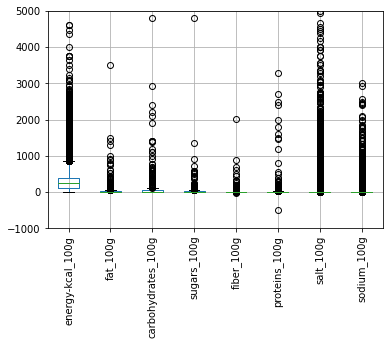

In [ ]:
#outlier
data.boxplot(column=['energy-kcal_100g','fat_100g', 'carbohydrates_100g', 'sugars_100g','fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g' ], vert=True, showfliers=True,autorange=True,rot=90)
plt.ylim(-1000,5000)

###Taux de Nan par entrée

In [ ]:
taux_Nan = [] 
    
for i in range(len(data_nutri)):
    taux_Nan.append(data_nutri.iloc[i].isnull().sum()/(len(data_nutri.columns))*100)

data_nutri['Taux NaN'] = taux_Nan
data_nutri.head(10)

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,Taux NaN
product_name,,,,,,,,,,,,,
moutarde au moût de raisin,NaN,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.600,1.8400,18.0,d,8.333333
Salade de carottes râpées,32.0,134.0,0.3,0.1,5.3,3.9,NaN,0.9,0.420,0.1680,1.0,b,8.333333
Tarte noix de coco,381.0,1594.0,22.0,15.5,27.3,21.9,4.4,4.6,0.100,0.0400,14.0,d,0.000000
Compote de poire,157.0,657.0,0.0,0.0,36.0,27.0,3.6,0.6,0.000,0.0000,-2.0,a,0.000000
Salade de macedoine de légumes,143.0,598.0,12.7,1.0,3.9,1.0,NaN,1.9,0.270,0.1080,1.0,b,8.333333
Abondance,397.0,1661.0,33.0,21.6,0.1,0.1,NaN,25.0,1.300,0.5200,14.0,d,8.333333
cuisse de poulet direct au four curry,197.0,824.0,13.0,4.0,3.0,0.9,NaN,17.0,1.100,0.4400,4.0,c,8.333333
Bagel,197.0,824.0,5.0,1.1,28.7,3.0,NaN,8.4,0.467,0.1868,0.0,b,8.333333
BAguette bressan,160.0,669.0,2.2,0.5,25.2,0.6,1.6,9.5,0.358,0.1432,-4.0,a,0.000000


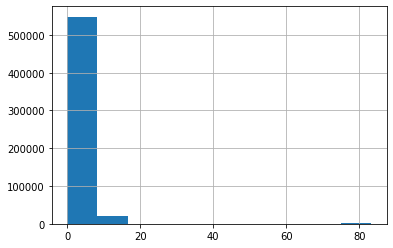

In [ ]:
data_nutri['Taux NaN'].hist()

In [ ]:
#nombre d'entrée
len(data_nutri)

571324

In [ ]:
#application d'un masque pour retirer les entrées n'ayant que des taux de NaN (100%) 
masque_NaN = data_nutri ['Taux NaN'] != 100
data_nutri_work = data_nutri[masque_NaN]
data_nutri_work.head()

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,Taux NaN
product_name,,,,,,,,,,,,,
moutarde au moût de raisin,NaN,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.60,1.840,18.0,d,8.333333
Salade de carottes râpées,32.0,134.0,0.3,0.1,5.3,3.9,NaN,0.9,0.42,0.168,1.0,b,8.333333
Tarte noix de coco,381.0,1594.0,22.0,15.5,27.3,21.9,4.4,4.6,0.10,0.040,14.0,d,0.000000
Compote de poire,157.0,657.0,0.0,0.0,36.0,27.0,3.6,0.6,0.00,0.000,-2.0,a,0.000000
Salade de macedoine de légumes,143.0,598.0,12.7,1.0,3.9,1.0,NaN,1.9,0.27,0.108,1.0,b,8.333333


In [ ]:
#nombre d'entrée restantes
len(data_nutri_work)

571324

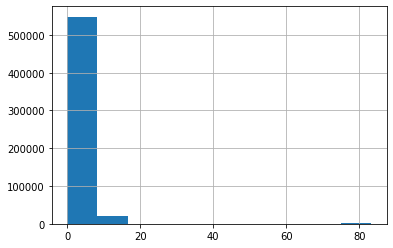

In [ ]:
data_nutri_work['Taux NaN'].hist()

In [ ]:
#application d'un masque pour retirer les entrées ayant des taux de NaN supérieur à 20% 
masque_NaN_20 = data_nutri_work ['Taux NaN'] <= 20
data_nutri_work = data_nutri_work[masque_NaN_20]
data_nutri_work.head(10)

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,Taux NaN
product_name,,,,,,,,,,,,,
moutarde au moût de raisin,NaN,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.600,1.8400,18.0,d,8.333333
Salade de carottes râpées,32.0,134.0,0.3,0.1,5.3,3.9,NaN,0.9,0.420,0.1680,1.0,b,8.333333
Tarte noix de coco,381.0,1594.0,22.0,15.5,27.3,21.9,4.4,4.6,0.100,0.0400,14.0,d,0.000000
Compote de poire,157.0,657.0,0.0,0.0,36.0,27.0,3.6,0.6,0.000,0.0000,-2.0,a,0.000000
Salade de macedoine de légumes,143.0,598.0,12.7,1.0,3.9,1.0,NaN,1.9,0.270,0.1080,1.0,b,8.333333
Abondance,397.0,1661.0,33.0,21.6,0.1,0.1,NaN,25.0,1.300,0.5200,14.0,d,8.333333
cuisse de poulet direct au four curry,197.0,824.0,13.0,4.0,3.0,0.9,NaN,17.0,1.100,0.4400,4.0,c,8.333333
Bagel,197.0,824.0,5.0,1.1,28.7,3.0,NaN,8.4,0.467,0.1868,0.0,b,8.333333
BAguette bressan,160.0,669.0,2.2,0.5,25.2,0.6,1.6,9.5,0.358,0.1432,-4.0,a,0.000000


In [ ]:
#nombre d'entrée restantes
len(data_nutri_work)

569710

###Création des set de training et set de test

In [ ]:
#division en 70/30 %
data_nutri_split = data_nutri_work.copy()
data_nutri_train, data_nutri_test = train_test_split(data_nutri_split, test_size=0.3)
data_nutri_train.shape, data_nutri_test.shape

((398797, 13), (170913, 13))

###Fonctions pour nettoyer les data set

####Set de training

In [ ]:
#fonction pour nettoyer le dataset de training
def nettoyage_dataset_train(datafram):

  from sklearn.preprocessing import StandardScaler
  from sklearn.impute import KNNImputer
  from sklearn.neighbors import KDTree
  import pickle

  frame=datafram.copy()

  #recherche de doublons dans la liste des noms de produit
  data_work_dou=frame.copy()
  data_work_dou=data_work_dou.reset_index()
  data_work_dou=data_work_dou.drop_duplicates(subset = ['product_name'] )
  data_work_dou=data_work_dou.reset_index(drop=True)
  
  #application d'un masque sur les entrées n'ayant que des valeurs nulles
  data_work_n=data_work_dou.copy()
  col_name1 = ['energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
       'sodium_100g']
  data_work_n['som_nul']= data_work_n[col_name1].sum(axis=1)
  masque_nul = data_work_n['som_nul']!=0
  data_work_nul=data_work_n[masque_nul]
  data_work_nul=data_work_nul.drop(['som_nul'],axis=1)
  data_work_nul=data_work_nul.reset_index(drop=True)

  #recherche des valeurs négatives (si valeur inf à 0 renvoi un NaN)
  data_work_nega=data_work_nul.copy()
  for col in col_name1:
    data_work_nega[col]=[val if val>=0 else np.NaN for val in data_work_nega[col]]

  #recherche de valeurs suppérieur à 100g (si valeur sup à 100 renvoi un NaN)
  data_work_sup=data_work_nega.copy()
  col_name2 = [ 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
       'sodium_100g']
  for col in col_name2:
    data_work_sup[col]=[val if val<=100 else np.NaN for val in data_work_sup[col]]

  #remplissage des NaN de la colonne energy en kcal à partir de la colonne energy en kJ   
  data_work_conv=data_work_sup.copy()
  conv = data_work_conv['energy_100g']*0.2388 #convertion kJ en kcal
  data_work_conv['energy-kcal_100g']=data_work_conv['energy-kcal_100g'].fillna(conv)
  data_work_conv=data_work_conv.drop('energy_100g', axis=1)

  #filtre sur energy-kcal_100g borné au 99.5eme percentile (si valeur sup renvoi un NaN)
  data_work_nrj_p=data_work_conv.copy()
  data_work_nrj_p['energy-kcal_100g']= data_work_nrj_p['energy-kcal_100g'].fillna(0)
  nrj_per= np.array(data_work_nrj_p['energy-kcal_100g'])
  per_99=np.percentile(nrj_per,99.5)
  data_work_nrj_pe=data_work_conv.copy()
  data_work_nrj_pe['energy-kcal_100g']=[val if val <= per_99  else np.NaN for val in data_work_nrj_pe['energy-kcal_100g']]

  #normalisation des data
  data_scale=data_work_nrj_pe.copy()
  col_name3 = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
        'carbohydrates_100g', 'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
        'sodium_100g','nutrition-score-fr_100g']
  scaler = StandardScaler()
  scal=scaler.fit_transform(data_scale[col_name3])
  pickle.dump(scaler, open('scaler_appli.pickle', 'wb'))
  data_scal=pd.DataFrame(scal,columns=col_name3)
  
  #imputation des NaN
  data_work_imp=data_scal.copy()
  imput=KNNImputer(n_neighbors=5)
  imp=imput.fit_transform(data_work_imp)
  pickle.dump(imput, open('imput_nettoyage_app.pickle', 'wb'))
  data_imp=pd.DataFrame(imp,columns=col_name3)

  #nettoyage des entrées par distance euclidienne
  tree = KDTree(data_imp)#calcul de la distance euclidienne entre les 5 plus proches voisins             
  dist, ind = tree.query(data_imp, k=5)
  data_dist=pd.DataFrame(dist)
  moy_dist = []
  for i in range ( len ( data_dist)):#Calcul la moyenne des distances euclidiennes pour chaque entrée
    moy_dist.append (data_dist.iloc[i].mean())
  
  #récupération des valeurs data
  data_to_invers=data_imp.copy()
  invers = scaler.inverse_transform(data_to_invers)
  data_invers=pd.DataFrame(invers,columns=col_name3)
  data_invers['product_name']=data_scale['product_name']
  data_invers['nutriscore_grade']=data_scale['nutriscore_grade']
  data_invers['moy_distance']=moy_dist
  data_invers=data_invers.reset_index(drop=True)
  
  # filtre sur le 99eme percentile de la distance euclidienne
  data_scale_dist_p=data_invers.copy()
  dist_per_99=np.percentile(data_scale_dist_p['moy_distance'],99)
  masque_dist_percentil = data_scale_dist_p ['moy_distance'] <= dist_per_99 
  data_work_dist_per99 = data_scale_dist_p[masque_dist_percentil]
  data_work_dist_per99=data_work_dist_per99.drop('moy_distance',axis=1)
  data_work_dist_per99=data_work_dist_per99.reset_index(drop=True)
  
  #suppression des entrées dont la somme de ses constituants est suppérieur à 100g
  data_imp_som=data_work_dist_per99.copy()
  data_imp_som['som']= data_imp_som['fat_100g'] + data_imp_som['carbohydrates_100g'] + data_imp_som['fiber_100g']+ data_imp_som['proteins_100g'] + data_imp_som['salt_100g']
  masque_100 = data_imp_som['som'] <= 100
  data_clean=data_imp_som[masque_100]
  data_clean=data_clean.drop(['som'],axis=1)
  data_clean=data_clean.reset_index(drop=True)

  #formatage du dataset cleané
  final_data=data_clean.copy()
  final_data['nutrition-score-fr_100g']=[val if val < -10**-1 or val > 10**-1 else 0 for val in final_data['nutrition-score-fr_100g']]
  final_data['fiber_100g']=[val if val < -10**-5 or val > 10**-5 else 0 for val in final_data['fiber_100g']]
  final_data['fat_100g']=[val if val < -10**-5 or val > 10**-5 else 0 for val in final_data['fat_100g']]
  final_data['sodium_100g']=[val if val < -10**-5 or val > 10**-5 else 0 for val in final_data['sodium_100g']]
  return final_data

In [ ]:
train_data_clean=nettoyage_dataset_train(data_nutri_train)

In [ ]:
train_data_clean.to_csv('train_data_clean.csv', sep = '\t')

####Set de test

In [ ]:
#fonction pour nettoyer le dataset de test
def nettoyage_dataset_test(datafram,scalerfit,imputfit):

  from sklearn.preprocessing import StandardScaler
  from sklearn.impute import KNNImputer
  from sklearn.neighbors import KDTree
  import pickle

  frame=datafram.copy()

  #recherche de doublons dans la liste des noms de produit
  data_work_dou=frame.copy()
  data_work_dou=data_work_dou.reset_index()
  data_work_dou=data_work_dou.drop_duplicates(subset = ['product_name'] )
  data_work_dou=data_work_dou.reset_index(drop=True)
  
  #application d'un masque sur les entrées n'ayant que des valeurs nulles
  data_work_n=data_work_dou.copy()
  col_name1 = ['energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
       'sodium_100g']
  data_work_n['som_nul']= data_work_n[col_name1].sum(axis=1)
  masque_nul = data_work_n['som_nul']!=0
  data_work_nul=data_work_n[masque_nul]
  data_work_nul=data_work_nul.drop(['som_nul'],axis=1)
  data_work_nul=data_work_nul.reset_index(drop=True)

  #recherche des valeurs négatives (si valeur inf à 0 renvoi un NaN)
  data_work_nega=data_work_nul.copy()
  for col in col_name1:
    data_work_nega[col]=[val if val>=0 else np.NaN for val in data_work_nega[col]]

  #recherche de valeurs suppérieur à 100g (si valeur sup à 100 renvoi un NaN)
  data_work_sup=data_work_nega.copy()
  col_name2 = [ 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
       'sodium_100g']
  for col in col_name2:
    data_work_sup[col]=[val if val<=100 else np.NaN for val in data_work_sup[col]]

  #remplissage des NaN de la colonne energy en kcal à partir de la colonne energy en kJ   
  data_work_conv=data_work_sup.copy()
  conv = data_work_conv['energy_100g']*0.2388 
  data_work_conv['energy-kcal_100g']=data_work_conv['energy-kcal_100g'].fillna(conv)
  data_work_conv=data_work_conv.drop('energy_100g', axis=1)

  #filtre sur energy-kcal_100g borné au 99.5eme percentile (si valeur sup renvoi un NaN)
  data_work_nrj_p=data_work_conv.copy()
  data_work_nrj_p['energy-kcal_100g']= data_work_nrj_p['energy-kcal_100g'].fillna(0)
  nrj_per= np.array(data_work_nrj_p['energy-kcal_100g'])
  per_99=np.percentile(nrj_per,99.5)
  data_work_nrj_pe=data_work_conv.copy()
  data_work_nrj_pe['energy-kcal_100g']=[val if val <= per_99  else np.NaN for val in data_work_nrj_pe['energy-kcal_100g']]

  #normalisation des data
  data_scale=data_work_nrj_pe.copy()
  col_name3 = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
        'carbohydrates_100g', 'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
        'sodium_100g','nutrition-score-fr_100g']
 
  scaler = pickle.load(open(scalerfit, 'rb'))
  scal=scaler.transform(data_scale[col_name3])
  data_scal=pd.DataFrame(scal,columns=col_name3)
  
  #imputation des NaN
  data_work_imp=data_scal.copy()
  imput = pickle.load(open(imputfit, 'rb'))
  imp=imput.transform(data_work_imp)
  data_imp=pd.DataFrame(imp,columns=col_name3)

  #nettoyage des entrées par distance euclidienne
  tree = KDTree(data_imp)            
  dist, ind = tree.query(data_imp, k=5)
  data_dist=pd.DataFrame(dist)
  moy_dist = []
  for i in range ( len ( data_dist)):
    moy_dist.append (data_dist.iloc[i].mean())
  
  #récupération des valeurs data
  data_to_invers=data_imp.copy()
  invers = scaler.inverse_transform(data_to_invers)
  data_invers=pd.DataFrame(invers,columns=col_name3)
  data_invers['product_name']=data_scale['product_name']
  data_invers['nutriscore_grade']=data_scale['nutriscore_grade']
  data_invers['moy_distance']=moy_dist
  data_invers=data_invers.reset_index(drop=True)
  
  # filtre sur le 99eme percentile de la distance euclidienne
  data_scale_dist_p=data_invers.copy()
  dist_per_99=np.percentile(data_scale_dist_p['moy_distance'],99)
  masque_dist_percentil = data_scale_dist_p ['moy_distance'] <= dist_per_99 
  data_work_dist_per99 = data_scale_dist_p[masque_dist_percentil]
  data_work_dist_per99=data_work_dist_per99.drop('moy_distance',axis=1)
  data_work_dist_per99=data_work_dist_per99.reset_index(drop=True)
  
  #suppression des entrées dont la somme de ses constituants est suppérieur à 100g
  data_imp_som=data_work_dist_per99.copy()
  data_imp_som['som']= data_imp_som['fat_100g'] + data_imp_som['carbohydrates_100g'] + data_imp_som['fiber_100g']+ data_imp_som['proteins_100g'] + data_imp_som['salt_100g']
  masque_100 = data_imp_som['som'] <= 100
  data_clean=data_imp_som[masque_100]
  data_clean=data_clean.drop(['som'],axis=1)
  data_clean=data_clean.reset_index(drop=True)

  #formatage du dataset cleané
  final_data=data_clean.copy()
  final_data['nutrition-score-fr_100g']=[val if val < -10**-1 or val > 10**-1 else 0 for val in final_data['nutrition-score-fr_100g']]
  final_data['fiber_100g']=[val if val < -10**-5 or val > 10**-5 else 0 for val in final_data['fiber_100g']]

  return final_data

In [ ]:
test_data_clean=nettoyage_dataset_test(data_nutri_test,'scaler_appli.pickle','imput_nettoyage_app.pickle')

In [ ]:
test_data_clean.to_csv('test_data_clean.csv', sep = '\t')